<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Классификация комментариев

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. Данные размечены

**Описание данных**

Столбец text в датасете содержит текст комментария, а toxic — целевой признак.

**Целевая метрика**
F1-мера

## Введение
Каждый раздел данного проекта будет поделен на четыре части, где будут производиться манипуляции для подготовки данных, обучения моделей и представление результатов для каждого из четырех выбранных способов решения задачи:
* TF-IDF + Логистическая регрессия;
* TF-IDF + CatBoost;
* BERT + Логистическая регрессия;
* BERT + CatBoost.

## Подготовка

Делаем фундаментальные заявления

In [1]:
# импортируем магию
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import torch
import transformers

from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix,\
                            ConfusionMatrixDisplay, classification_report,\
                            plot_roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import notebook


Загружаем датасет

In [2]:
try:
    df = pd.read_csv('')
except:
    df = pd.read_csv('')


Посмотрим на данные

In [3]:
display(df.head())
print(df.shape)
df['toxic'].value_counts()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


(159571, 2)


0    143346
1     16225
Name: toxic, dtype: int64

Классы даже близко не сбалансированы.

Сократим выборку в 10 раз. После проверим, сохранились ли пропорции классов, необходимые для чистоты эксперимента.

In [4]:
short_df = df.sample(len(df)//10, random_state=2007)
short_df = short_df.reset_index(drop=True)
display(short_df.head())
short_df['toxic'].value_counts()


,text,toxic
0,"""\n\n A Helpful Haiku \nMeaneager, I've writte...",0
1,The injury of The Undertaker \n\nI think it's ...,0
2,"""\n Deletion discussion about JD Lighting \nHe...",0
3,"""\nYou're welcome! Glad to help you. talk & c...",0
4,So you're trying to justify the block because ...,0


0    14322
1     1635
Name: toxic, dtype: int64

Пропорции похожи.

Приступим к работе по подготовке данных. 

### TF-IDF + Logit
В первую очередь нам необходимо провести предобработку непосредственно текстов. Библиотека `Spacy` поможет это там сделать легко и непринужденно.

Загрузим и сохраним словарь.

In [5]:
nlp = spacy.load("en_core_web_sm")

Проведем работу по лемматизации, забудем стоп-слова и удалим знаки препинания. Сначала принизим все буквы до строчных, иначе есть риск оставить стоп-слова.

In [6]:
short_df['text'] = short_df['text'].apply(lambda text: text.lower())

short_df.sample(10)

,text,toxic
2143,who the f*ck put you in charge\n\ni create an ...,1
13886,"i'll go ahead and submit it, if you like. do y...",0
8342,"""\ni have created the next newsletter and will...",0
217,"""\n\n wp:india banner/delhi addition \nnote: ...",0
15110,"""\n\n dubious association \ni don't see how th...",0
15091,telos \n\ni have added telos to the home plane...,0
14996,"""listen, it was """"interesting"""" meeting a wiki...",0
15638,congratulations! \n\nyour furious defense of t...,1
8169,"notability bs, i note that 3 of the 4 links th...",1
13185,...also note - giving early warnings may const...,0


Теперь перейдем, непосредственно, к делу

In [7]:
%%time
short_df['lemm_text'] = (short_df['text']
                         .apply(lambda text: 
                                " ".join(token.lemma_ for token in nlp(text) 
                                         if not (token.is_stop or token.is_punct or token.is_space or
                                                token.like_url or token.like_email or token.like_num))))

CPU times: user 4min 12s, sys: 5.79 s, total: 4min 17s
Wall time: 4min 18s


In [8]:
short_df.sample(10)

,text,toxic,lemm_text
12433,"""\nthank you toddst1 for unblocking me. regard...",0,thank toddst1 unblock rollback explain happen ...
1995,makingdeath threats and leaving your ip addres...,1,makingdeath threat leave ip address height stu...
10657,2008 (utc)\n\nah! blanking the bits you don't...,0,utc ah blank bit like include justified vandal...
8025,"""\n\n some minor revisions to the 1st paragrap...",0,minor revision 1st paragraph definition sectio...
4766,"""\n\nonce again !!!!\n\nyou continue to fail t...",0,continue fail address fact vandalism define te...
6265,fuck your mama u fucking suck mother fucker,1,fuck mama u fucking suck mother fucker
9428,yadda yadda yadda. nothing you've just said is...,1,yadda yadda yadda say relavent clearly know ad...
10568,dear hindu friend: thank you for your contribu...,0,dear hindu friend thank contribution guess idl...
15032,"""::would """"(religious)"""" be a better disambigu...",0,religious well disambiguator
11923,regardless. dont ever touch my user page again...,0,regardless not touch user page get mgiht team ...


Обзначим фичи и таргет

In [9]:
X_tfidf = short_df['lemm_text']
y_tfidf = short_df['toxic']
X_tfidf.shape, y_tfidf.shape

((15957,), (15957,))

Разобьем выборку на трейн и тест

In [10]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, 
                                                                            y_tfidf, 
                                                                            test_size=0.25, 
                                                                            random_state=2007)

X_train_tfidf.shape, X_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape

((11967,), (3990,), (11967,), (3990,))

Превратим наш набор слов в векторы

In [11]:
%%time
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train_tfidf) 
X_test_tfidf = vect.transform(X_test_tfidf) 

CPU times: user 651 ms, sys: 9 ms, total: 660 ms
Wall time: 666 ms


К обучению моделей все готово.

### TF-IDF + CatBoost
Настроем Pool и параметры, укажем вес классов

Создаем Pool

In [12]:
train_data_cb = Pool(X_train_tfidf, 
                    y_train_tfidf)

test_data_cb = Pool(X_test_tfidf, 
                    y_test_tfidf)

Взвесим классы, чтобы лучше настроить модель

In [13]:
cw = [1,(y_train_tfidf==0).sum() / (y_train_tfidf==1).sum()]
cw

[1, 8.543062200956937]

Объявим параметры модели

In [14]:
params_cb = {'eval_metric': 'F1', 
             'loss_function': 'Logloss',
             'learning_rate': 0.1,
             'random_seed': 42,
             'verbose':100,
             'depth':10,
             'l2_leaf_reg':9}

Оcтавим дефолтное значение. Все готово к обучению!

### BERT + Логит

Оставим в предложениях только английские слова, используя регулярные выражения

Загрузим токенайзер

In [15]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Собственно, токенизируем

In [16]:
%%time
tokenized = short_df['text'].apply(
    lambda x: tokenizer.encode(x, 
                               add_special_tokens=True, 
                               max_length=512, 
                               truncation=True))

CPU times: user 49.4 s, sys: 102 ms, total: 49.5 s
Wall time: 49.7 s


Оставим только 15900 строк, т.к. батчи будут по 100 элементов, и нам необходимо иметь и фичи, и таргеты, кратными им

In [17]:
short_df = short_df[0:15900]
tokenized = tokenized[0:15900]
short_df.shape, tokenized.shape

((15900, 3), (15900,))

Выровняем длины строк, добавив коротким строкам нули и сохраним в маску строки без них.

In [18]:
padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Создадим копию класса модели и укажем, что будем работать с GPU

In [19]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

BERT_model = transformers.BertModel.from_pretrained('unitary/toxic-bert')
BERT_model = BERT_model.to(device)

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Нарежем батчей, создадим эмбеддинги

In [20]:
%%time
batch_size = 100
embeddings = [] 
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            BERT_model
            batch_embeddings = BERT_model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        
        del batch
        del attention_mask_batch
        del batch_embeddings

features = np.concatenate(embeddings) 

  0%|          | 0/159 [00:00<?, ?it/s]

CPU times: user 4min 10s, sys: 364 ms, total: 4min 10s
Wall time: 4min 11s


Объявим фичи и таргет

In [21]:
X_bert = np.concatenate(embeddings)
y_bert = short_df['toxic']
X_bert.shape, y_bert.shape

((15900, 768), (15900,))

Раделим на трейн и тест

In [22]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, 
                                                           y_bert, 
                                                           test_size=0.25, 
                                                           random_state=2007)

X_train_bert.shape, X_test_bert.shape, y_train_bert.shape, y_test_bert.shape

((11925, 768), (3975, 768), (11925,), (3975,))

Можно на подиум

### BERT + CatBoost
Объявим Pool, зададим вес классов.

In [23]:
train_data_cb_bert = Pool(X_train_bert, 
                    y_train_bert)

test_data_cb_bert = Pool(X_test_bert, 
                    y_test_bert)

In [24]:
cw_bert = [1,(y_train_bert==0).sum() / (y_train_bert==1).sum()]
cw_bert

[1, 8.750613246116108]

## Обучение

### TF-IDF + Logit
Переберем гиперпараметры и обучим модель.

In [25]:
param_grid = {'C': [0.01, 0.1, 1.0, 10, 100],
             'tol': [0.0001, 0.001, 0.01, 0.1, 1]}

In [26]:
%%time
lr_model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=2007)
grid = GridSearchCV(lr_model, param_grid, scoring='f1')
grid.fit(X_train_tfidf, y_train_tfidf)
grid.best_estimator_

CPU times: user 1min 20s, sys: 54.8 s, total: 2min 15s
Wall time: 1min 13s


LogisticRegression(C=10, class_weight='balanced', max_iter=10000,
                   random_state=2007)

Применим модель на тестовой выборке и оценим метрику F1

0.7334200260078023
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3609
           1       0.73      0.74      0.73       381

    accuracy                           0.95      3990
   macro avg       0.85      0.86      0.85      3990
weighted avg       0.95      0.95      0.95      3990



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


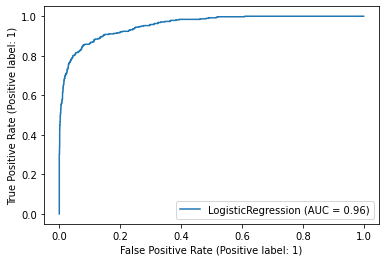

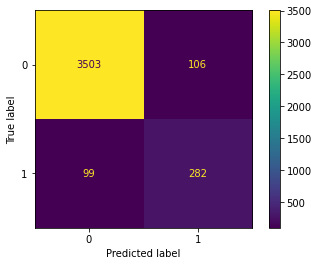

In [27]:
y_pred_tfidf = grid.best_estimator_.predict(X_test_tfidf)
# напишем функцию по выводу метрик
def scoring(model, X_test, y_test, prediction):
    print(f1_score(y_test, prediction))
    print(classification_report(y_test, prediction))
    plot_roc_curve(model, X_test, y_test); 
    
    cm = confusion_matrix(y_test, prediction, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()

    plt.show()

# применим ее
scoring(grid.best_estimator_, X_test_tfidf, y_test_tfidf, y_pred_tfidf)

Почти хорошо

### TF-IDF + CatBoost
Теперь обучим кэтбуст и посмотрим на его результаты

In [28]:
%%time

model_cb = CatBoostClassifier(**params_cb, 
                              class_weights=cw)
model_cb.fit(train_data_cb)

0:	learn: 0.7006650	total: 2.49s	remaining: 41m 28s
100:	learn: 0.8788042	total: 4m 17s	remaining: 38m 13s
200:	learn: 0.9473963	total: 8m 34s	remaining: 34m 4s
300:	learn: 0.9913019	total: 12m 50s	remaining: 29m 48s
400:	learn: 0.9932780	total: 17m 6s	remaining: 25m 33s
500:	learn: 0.9946152	total: 21m 22s	remaining: 21m 17s
600:	learn: 0.9958634	total: 25m 39s	remaining: 17m 1s
700:	learn: 0.9967900	total: 29m 54s	remaining: 12m 45s
800:	learn: 0.9977647	total: 34m 9s	remaining: 8m 29s
900:	learn: 0.9986018	total: 38m 24s	remaining: 4m 13s
999:	learn: 0.9999067	total: 42m 36s	remaining: 0us
CPU times: user 1h 19min 47s, sys: 15.8 s, total: 1h 20min 3s
Wall time: 42min 38s


Применим модель на тестовой выборке, оценим метрики

0.7560321715817694
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3609
           1       0.77      0.74      0.76       381

    accuracy                           0.95      3990
   macro avg       0.87      0.86      0.87      3990
weighted avg       0.95      0.95      0.95      3990



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


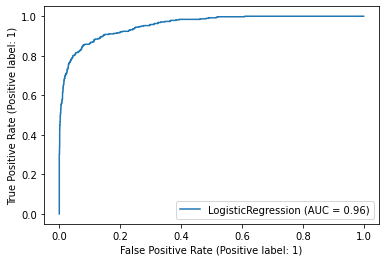

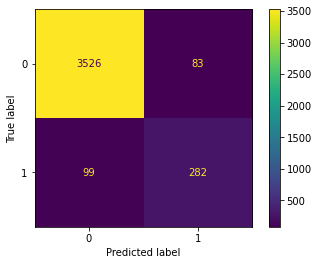

In [29]:
y_pred_cb = model_cb.predict(X_test_tfidf)
scoring(grid.best_estimator_, X_test_tfidf, y_test_tfidf, y_pred_cb)

Уже лучше

### BERT + Logit
Обучим логистическую регрессию на данных

In [30]:
%%time
lr_bert_model = LogisticRegression(solver='liblinear', random_state=2007)
grid = GridSearchCV(lr_bert_model, param_grid, scoring='f1')
grid.fit(X_train_bert, y_train_bert)
grid.best_estimator_

CPU times: user 5min 30s, sys: 18.1 s, total: 5min 48s
Wall time: 5min 33s


LogisticRegression(random_state=2007, solver='liblinear', tol=0.1)

Применим модель на тестовой выборке и оценим метрику F1

0.9376558603491272
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3571
           1       0.94      0.93      0.94       404

    accuracy                           0.99      3975
   macro avg       0.97      0.96      0.97      3975
weighted avg       0.99      0.99      0.99      3975



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


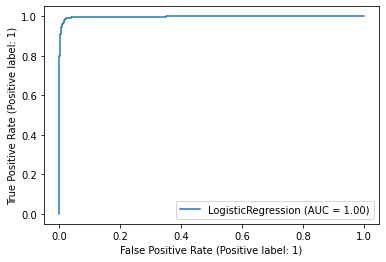

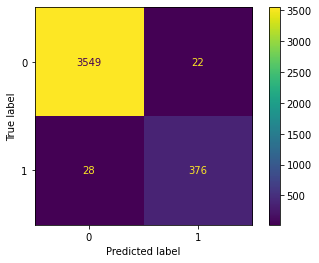

In [31]:
y_pred_bert = grid.best_estimator_.predict(X_test_bert)
scoring(grid.best_estimator_, X_test_bert, y_test_bert, y_pred_bert)

Эмбеддинги BERT творят чудеса. Всего 50 ошибок на 3975 строк.

### BERT + CatBoost
Обучим CatBoost на эмбеддингах

In [32]:
%%time
model_cb_bert = CatBoostClassifier(**params_cb,
                                   class_weights=cw_bert)

model_cb_bert.fit(train_data_cb_bert)

0:	learn: 0.9774681	total: 1.78s	remaining: 29m 36s
100:	learn: 0.9981812	total: 3m 6s	remaining: 27m 37s
200:	learn: 0.9991597	total: 6m 11s	remaining: 24m 34s
300:	learn: 0.9994397	total: 9m 15s	remaining: 21m 31s
400:	learn: 0.9994397	total: 12m 19s	remaining: 18m 24s
500:	learn: 0.9994397	total: 15m 23s	remaining: 15m 19s
600:	learn: 0.9994397	total: 18m 27s	remaining: 12m 15s
700:	learn: 0.9994397	total: 21m 31s	remaining: 9m 10s
800:	learn: 0.9994397	total: 24m 35s	remaining: 6m 6s
900:	learn: 0.9994397	total: 27m 39s	remaining: 3m 2s
999:	learn: 0.9994397	total: 30m 44s	remaining: 0us
CPU times: user 58min 15s, sys: 6.67 s, total: 58min 22s
Wall time: 30min 45s


Применим модель на тестовой выборке и оценим метрику F1

0.9330143540669857
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3571
           1       0.90      0.97      0.93       404

    accuracy                           0.99      3975
   macro avg       0.95      0.98      0.96      3975
weighted avg       0.99      0.99      0.99      3975



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


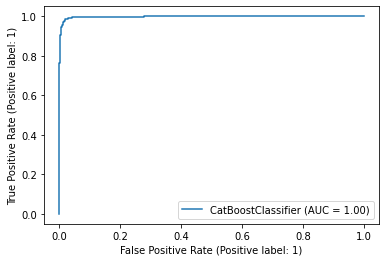

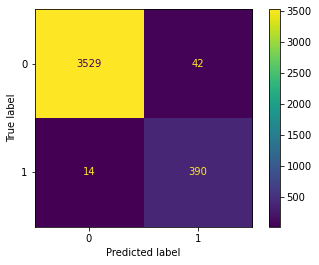

In [33]:
y_pred_cb_bert = model_cb_bert.predict(X_test_bert)
scoring(model_cb_bert, X_test_bert, y_test_bert, y_pred_cb_bert)

Судя, по всему можно было ограничиться 100-200 итерациями или включить early_stopping_rounds. В любом случая, видно, что бустинг превзоршел более простую логитическую регрессию только по полноте.

## Выводы

Из всех путей решения задачи классификации текстов с точки зрения метрики F1, в данном проекте без эмебддингов BERT наиболее эффективной получилась комбинация TF_IDF + Catboost, где была достигнуто значение целевой метрики F1 = 0.75. Результат, равный 0.72 дали TF_IDF + Логистическая регрессия. 

Модели с BERT, в значительной степени превзошли традиционный подход. Логистическая регрессия показала результат F1=0.938, CatBoost - на 0.5 меньше. Исходя из этого, можно сделать вывод, что при сопоставимом результате очевидно имеет смысли использовать более простую модель лошистической регрессии.